# Assessment of the Generalization Error of SGD in Deep Neural Network

In [1]:
#----- Import libraries -----

import os
import random
import tikzplotlib

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms

torch.manual_seed(0)
random.seed(0)

#----- Define the path to the data set -----

DATADIR = "./Data"
train_dir = os.path.join(DATADIR, "vegetables", "train")
valid_dir = os.path.join(DATADIR, "vegetables", "val")
classes = ( "Bean", "Bitter_Gourd", "Broccoli", "Cabbage", "Potato", "Pumkin", "Cucumber", "Cauliflower", "Carrot", "Capsicum" )

In [ ]:
#----- Getting the mean and std of pictures across different channels for image preprocessing (normalization) -----

def get_mean_and_std(dataloader):
    
    channels_sum = 0
    channels_squared_sum = 0
    num_batches = 0
    
    for data, _ in dataloader:

        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

#----- Caluclate the mean and the variance for the transformation after resizing the image to 224 -----

# This is done because an instance of the AlexNet structure will be used. More specifically, we will use the convolutional
# feature extraction part of the neural network and then tranin a classification network from scratch.

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(224),
        ])

raw_train_data = datasets.ImageFolder(train_dir, transform)
mean_std_dataloader = torch.utils.data.DataLoader(raw_train_data, batch_size=64)

mean, std = get_mean_and_std(mean_std_dataloader)

print(f'Mean and std: {mean}, {std}')

In [ ]:
#----- Create the train and validation data sets -----

transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = mean, std = std)
        ])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(train_dir, transform)

#----- Create the train and validation data loaders -----

def data_loaders(batch_size):
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
    
    return train_loader, valid_loader

In [ ]:
#----- Loading a pre-trained AlexNet model -----

model = models.alexnet(pretrained=True)

#----- Freezing all the parameters in the feature extraction layers -----

for param in model.features.parameters():
    param.requires_grad = False

#----- Creating a new classification architecture to train from scratch -----

model.classifier[1] = nn.Linear(9216, 1024, bias=True)
model.classifier[4] = nn.Linear(1024 , 128, bias=True)
model.classifier[6] = nn.Linear(128 , 10 , bias=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device is: " + str(device))

model.to(device)

In [ ]:
#----- Function that performs training for one epoch -----

def train_one_epoch(net, loader, criterion, optimizer, device, lr):
    
    net.train()    
    
    for g in optimizer.param_groups:
        g['lr'] = lr
    
    total_loss = 0
    
    for i, (batch, target) in enumerate(loader):
     
        batch = batch.to(device)
        target = target.to(device)
        
        output = net(batch)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    #----- Return the average loss per batch ----- 
    
    return total_loss/len(loader)

In [ ]:
#----- Function that calculates the number of correctly classified images -----

def count_nb_correct(output, target):

    n_correct = 0
    
    predicted = output.argmax(dim=1, keepdim=True)
    n_correct = predicted.eq(target.view_as(predicted)).sum().item()
    
    return n_correct

In [ ]:
#----- Function that calculates percentage of correctly clasified images on a particular data set -----

def validate(net, loader, device):
    
    net.eval()
    
    n_correct = 0
    
    with torch.no_grad():
        
        for i, (batch, target) in enumerate(loader):
            
            batch = batch.to(device)
            target = target.to(device)
            
            output = net(batch)
            n_correct += count_nb_correct(output, target)
            
    return float(n_correct)/float(len(loader.dataset))

# SGD with a fixed learning rate and a fixed batch size

In this section we will

1) train the classification network of the model for different batch sizes while keeping a fixed learning rate

2) train the classification network of the model for different learning rates while keeping the same batch size

In order to test the scalability, we will test batch sizes of 16, 32, 64, 128, 256, 512 and the learning rates of 0.0001, 0.0002, 0.0004, 0.0008, 0.0016 and 0.0032.

In [ ]:
#----- Train function for a predefined number of epochs -----

def train(net, train_loader, valid_loader, criterion, optimizer, device, n_epochs, lr):
    
    epochs = []
    train_losses = []
    valid_accuracies = []
    
    print(f"The training is done on the {'GPU' if next(net.parameters()).is_cuda else 'CPU'}")
    
    for epoch in range(n_epochs):

        train_loss = train_one_epoch(net, train_loader, criterion, optimizer, device, lr)
        
        epochs.append(epoch)
        train_losses.append(train_loss)

        accuracy = validate(net, valid_loader, device)
        valid_accuracies.append(accuracy)
        
        print(f"epoch {epoch} loss {train_loss:.3f} accuracy {100*accuracy:.2f}%")
        
    return epochs, train_losses, valid_accuracies, net

In [2]:
#----- Create a path and folder for storing the results -----

current_folder = os.getcwd()

file = current_folder + '/Results'

if not os.path.isdir(file):
    os.makedirs(file)

folder_step_1 = file + '/SGD with fixed learning rate and fixed batch size'
if not os.path.isdir(folder_step_1):
    os.makedirs(folder_step_1)

In [ ]:
#----- Main function for testing convergence for different batch sizes -----

batch_sizes = [16, 32, 64, 128, 256, 512]
learning_rate = 0.0001

n_epochs = 150

#----- Train -----

for batch_size in batch_sizes:
    
    train_loader, valid_loader = data_loaders(batch_size)
    
    for param in model.features.parameters():
        param.requires_grad = False

    #----- Reseting the parameters of the classification model -----

    model.classifier[1] = nn.Linear(9216, 1024, bias=True)
    model.classifier[4] = nn.Linear(1024 , 128, bias=True)
    model.classifier[6] = nn.Linear(128 , 10 , bias=True)
    
    model.to(device)
    
    #----- Using the Cross entropy loss for 10-class classification problem -----
    
    criterion = nn.CrossEntropyLoss()
    
    #----- Using the SGD optimizer with momentum 0.9 -----
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    criterion.to(device)
    
    epochs, train_losses, valid_accuracies, net = train(model, train_loader, valid_loader, criterion, optimizer, device, n_epochs, learning_rate)
    
    #----- Saving the train loss and validation accuracy curves for each batch size -----
    
    np.save(folder_step_1 + f'/train_losses_{batch_size}_{int(learning_rate*10000)}.npy', np.array(train_losses))
    np.save(folder_step_1 + f'/valid_accuracies_{batch_size}_{int(learning_rate*10000)}.npy', np.array(valid_accuracies))
    
    torch.save(model.state_dict(), folder_step_1 + f'/Model_{batch_size}_{int(learning_rate*10000)}.pt')
    
np.save(folder_step_1 + '/epochs.npy', np.array(epochs)) 

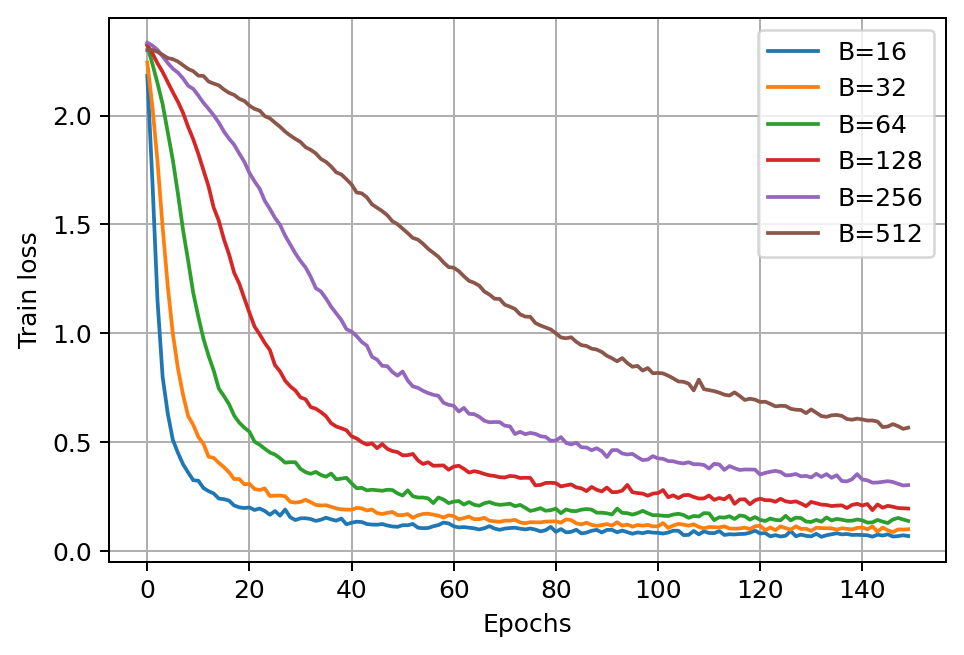

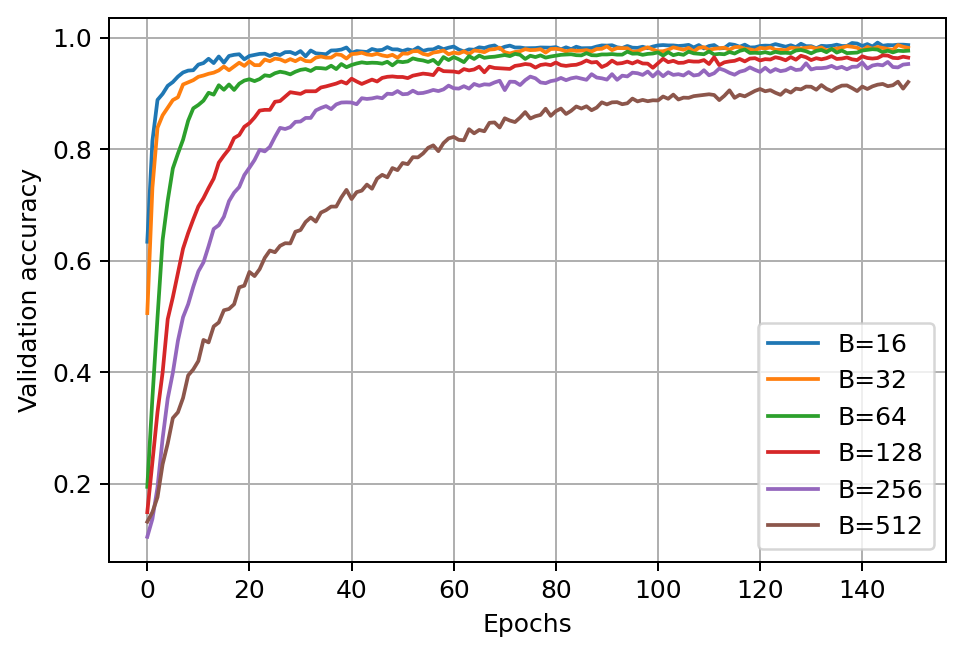

In [3]:
#----- Plotting function 1 -----

tl_16  = np.load(folder_step_1 + '/train_losses_16_1.npy')
tl_32  = np.load(folder_step_1 + '/train_losses_32_1.npy')
tl_64  = np.load(folder_step_1 + '/train_losses_64_1.npy')
tl_128 = np.load(folder_step_1 + '/train_losses_128_1.npy')
tl_256 = np.load(folder_step_1 + '/train_losses_256_1.npy')
tl_512 = np.load(folder_step_1 + '/train_losses_512_1.npy')

va_16  = np.load(folder_step_1 + '/valid_accuracies_16_1.npy')
va_32  = np.load(folder_step_1 + '/valid_accuracies_32_1.npy')
va_64  = np.load(folder_step_1 + '/valid_accuracies_64_1.npy')
va_128 = np.load(folder_step_1 + '/valid_accuracies_128_1.npy')
va_256 = np.load(folder_step_1 + '/valid_accuracies_256_1.npy')
va_512 = np.load(folder_step_1 + '/valid_accuracies_512_1.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')

fig1, ax1 = plt.subplots(dpi=180)

ax1.plot(epochs, tl_16, label='B=16')
ax1.plot(epochs, tl_32, label='B=32')
ax1.plot(epochs, tl_64, label='B=64')
ax1.plot(epochs, tl_128, label='B=128')
ax1.plot(epochs, tl_256, label='B=256')
ax1.plot(epochs, tl_512, label='B=512')

ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train loss')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot.tex")

fig1.savefig(folder_step_1 + "/comparison_plot.jpg", dpi=180)

#----- Validation accuracy -----

fig2, ax2 = plt.subplots(dpi=180)

ax2.plot(epochs, va_16, label='B=16')
ax2.plot(epochs, va_32, label='B=32')
ax2.plot(epochs, va_64, label='B=64')
ax2.plot(epochs, va_128, label='B=128')
ax2.plot(epochs, va_256, label='B=256')
ax2.plot(epochs, va_512, label='B=512')

ax2.grid('on')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation accuracy')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot_validation.tex")

fig2.savefig(folder_step_1 + "/comparison_plot_validation.jpg", dpi=180)


In [ ]:
#----- Main function for testing convergence for different learing rates and biggest batch sizes -----

n_epochs = 150

#----- We test for B=256 and B=512 -----

batch_sizes = [256, 512]
learning_rates = [0.0002, 0.0004, 0.0008, 0.0016, 0.0032]

#----- Train -----

for batch_size in batch_sizes:
    
    train_loader, valid_loader = data_loaders(batch_size)
    
    for learning_rate in learning_rates:
    
        for param in model.features.parameters():
            param.requires_grad = False

        #----- Reseting the parameters of the classification model -----

        model.classifier[1] = nn.Linear(9216, 1024, bias=True)
        model.classifier[4] = nn.Linear(1024 , 128, bias=True)
        model.classifier[6] = nn.Linear(128 , 10 , bias=True)
    
        model.to(device)
    
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
        criterion.to(device)
    
        epochs, train_losses, valid_accuracies, net = train(model, train_loader, valid_loader, criterion, optimizer, device, n_epochs, learning_rate)
    
        np.save(folder_step_1 + f'/train_losses_{batch_size}_{int(learning_rate*10000)}.npy', np.array(train_losses))
        np.save(folder_step_1 + f'/valid_accuracies_{batch_size}_{int(learning_rate*10000)}.npy', np.array(valid_accuracies))
    
        torch.save(model.state_dict(), folder_step_1 + f'/Model_{batch_size}_{int(learning_rate*10000)}.pt')

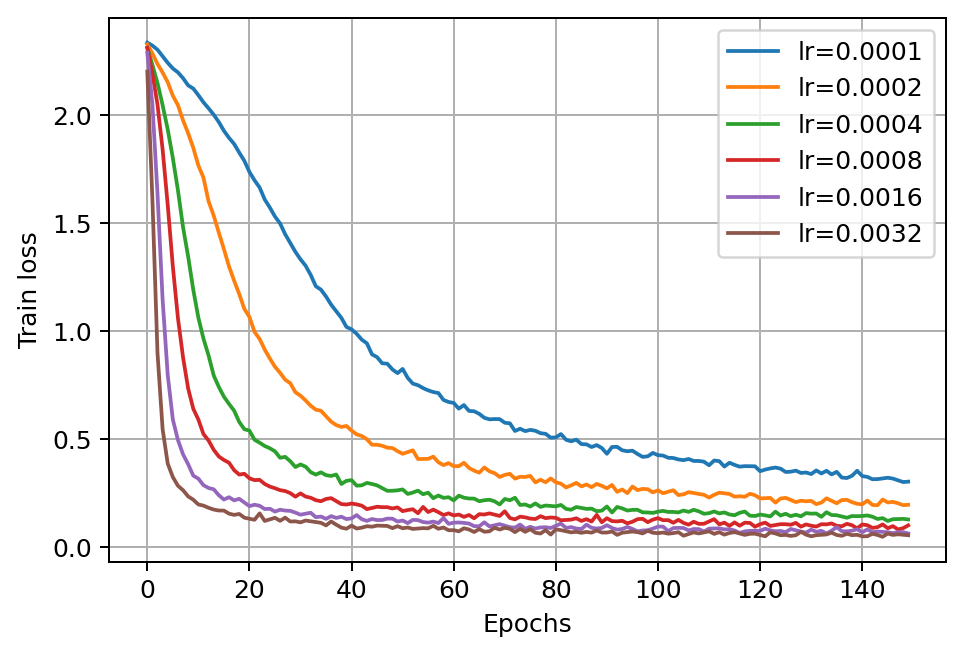

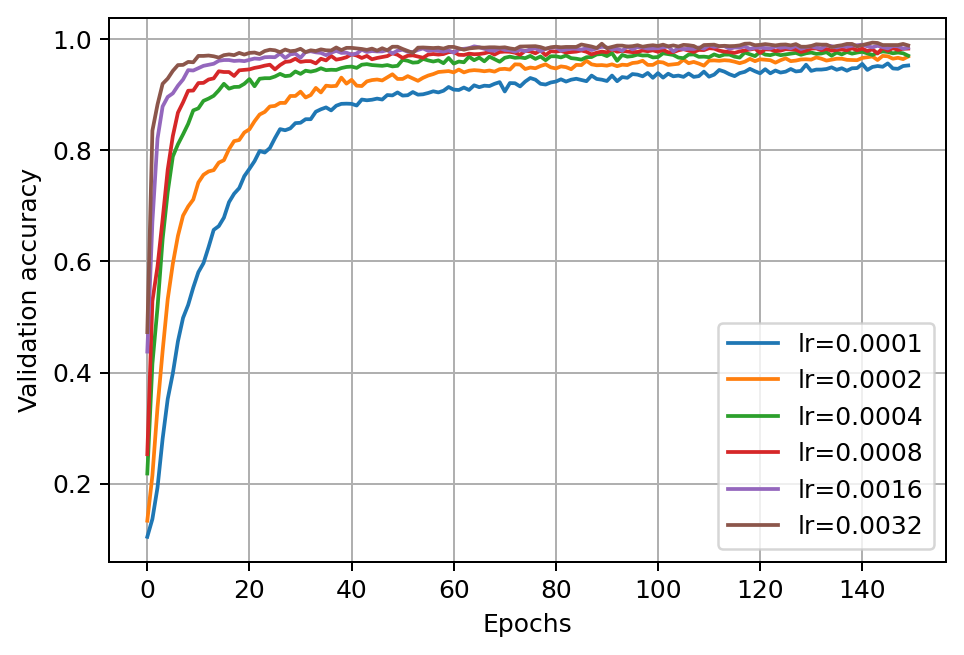

In [4]:
#----- Plot different lr for batch_size = 256 -----

tl_256_1 = np.load(folder_step_1 + '/train_losses_256_1.npy')
tl_256_2 = np.load(folder_step_1 + '/train_losses_256_2.npy')
tl_256_3 = np.load(folder_step_1 + '/train_losses_256_4.npy')
tl_256_4 = np.load(folder_step_1 + '/train_losses_256_8.npy')
tl_256_5 = np.load(folder_step_1 + '/train_losses_256_16.npy')
tl_256_6 = np.load(folder_step_1 + '/train_losses_256_32.npy')

va_256_1 = np.load(folder_step_1 + '/valid_accuracies_256_1.npy')
va_256_2 = np.load(folder_step_1 + '/valid_accuracies_256_2.npy')
va_256_3 = np.load(folder_step_1 + '/valid_accuracies_256_4.npy')
va_256_4 = np.load(folder_step_1 + '/valid_accuracies_256_8.npy')
va_256_5 = np.load(folder_step_1 + '/valid_accuracies_256_16.npy')
va_256_6 = np.load(folder_step_1 + '/valid_accuracies_256_32.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')

fig1, ax1 = plt.subplots(dpi=180)

ax1.plot(epochs, tl_256_1, label='lr=0.0001')
ax1.plot(epochs, tl_256_2, label='lr=0.0002')
ax1.plot(epochs, tl_256_3, label='lr=0.0004')
ax1.plot(epochs, tl_256_4, label='lr=0.0008')
ax1.plot(epochs, tl_256_5, label='lr=0.0016')
ax1.plot(epochs, tl_256_6, label='lr=0.0032')

ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train loss')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot_256_lrs.tex")

fig1.savefig(folder_step_1 + "/comparison_plot_256_lrs.jpg", dpi=180)

#----- Validation accuracy -----

fig2, ax2 = plt.subplots(dpi=180)

ax2.plot(epochs, va_256_1, label='lr=0.0001')
ax2.plot(epochs, va_256_2, label='lr=0.0002')
ax2.plot(epochs, va_256_3, label='lr=0.0004')
ax2.plot(epochs, va_256_4, label='lr=0.0008')
ax2.plot(epochs, va_256_5, label='lr=0.0016')
ax2.plot(epochs, va_256_6, label='lr=0.0032')

ax2.grid('on')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation accuracy')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot_validation_256_lrs.tex")

fig2.savefig(folder_step_1 + "/comparison_plot_validation_256_lrs.jpg", dpi=180)

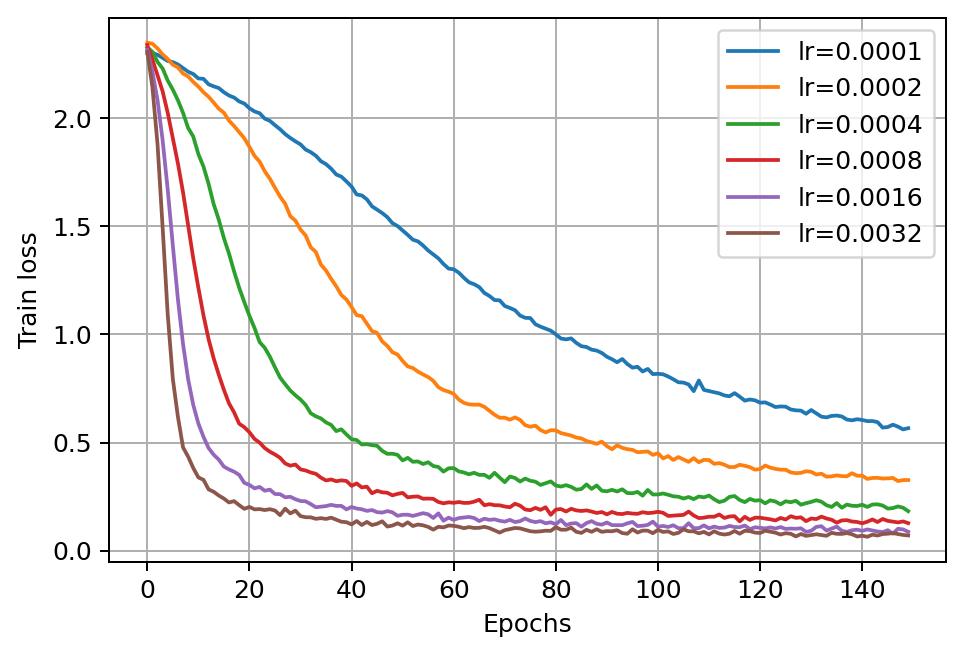

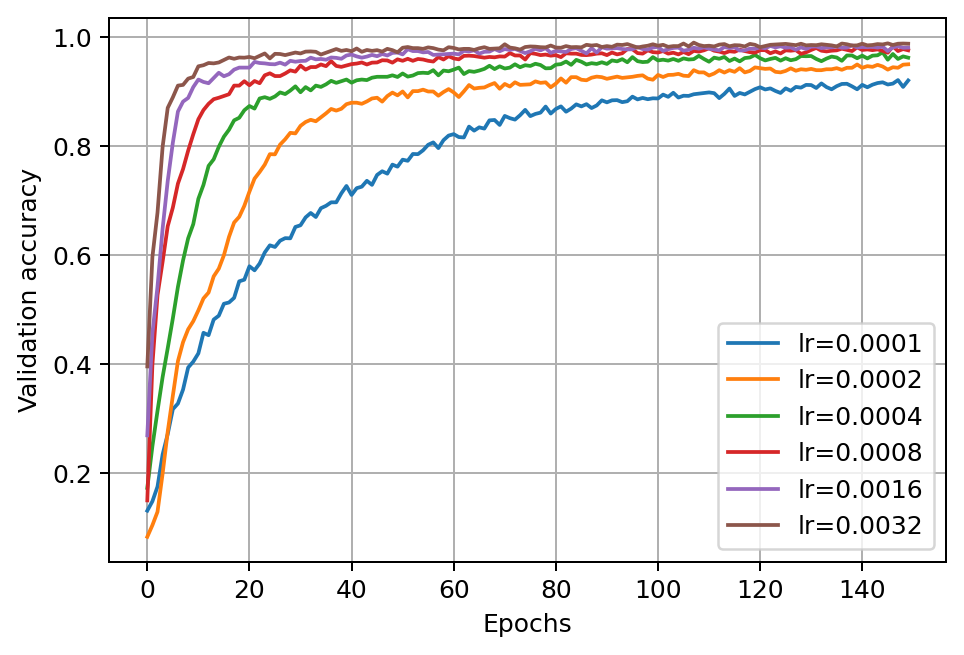

In [5]:
#----- Plot different lr for batch_size = 512 -----

tl_512_1 = np.load(folder_step_1 + '/train_losses_512_1.npy')
tl_512_2 = np.load(folder_step_1 + '/train_losses_512_2.npy')
tl_512_3 = np.load(folder_step_1 + '/train_losses_512_4.npy')
tl_512_4 = np.load(folder_step_1 + '/train_losses_512_8.npy')
tl_512_5 = np.load(folder_step_1 + '/train_losses_512_16.npy')
tl_512_6 = np.load(folder_step_1 + '/train_losses_512_32.npy')

va_512_1 = np.load(folder_step_1 + '/valid_accuracies_512_1.npy')
va_512_2 = np.load(folder_step_1 + '/valid_accuracies_512_2.npy')
va_512_3 = np.load(folder_step_1 + '/valid_accuracies_512_4.npy')
va_512_4 = np.load(folder_step_1 + '/valid_accuracies_512_8.npy')
va_512_5 = np.load(folder_step_1 + '/valid_accuracies_512_16.npy')
va_512_6 = np.load(folder_step_1 + '/valid_accuracies_512_32.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')

fig1, ax1 = plt.subplots(dpi=180)

ax1.plot(epochs, tl_512_1, label='lr=0.0001')
ax1.plot(epochs, tl_512_2, label='lr=0.0002')
ax1.plot(epochs, tl_512_3, label='lr=0.0004')
ax1.plot(epochs, tl_512_4, label='lr=0.0008')
ax1.plot(epochs, tl_512_5, label='lr=0.0016')
ax1.plot(epochs, tl_512_6, label='lr=0.0032')

ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train loss')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot_512_lrs.tex")

fig1.savefig(folder_step_1 + "/comparison_plot_512_lrs.jpg", dpi=180)

#----- Validation accuracy -----

fig2, ax2 = plt.subplots(dpi=180)

ax2.plot(epochs, va_512_1, label='lr=0.0001')
ax2.plot(epochs, va_512_2, label='lr=0.0002')
ax2.plot(epochs, va_512_3, label='lr=0.0004')
ax2.plot(epochs, va_512_4, label='lr=0.0008')
ax2.plot(epochs, va_512_5, label='lr=0.0016')
ax2.plot(epochs, va_512_6, label='lr=0.0032')

ax2.grid('on')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation accuracy')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_1 + "/comparison_plot_validation_512_lrs.tex")

fig2.savefig(folder_step_1 + "/comparison_plot_validation_512_lrs.jpg", dpi=180)

# SGD with dynamic learning rate and fixed batch sizes

In this section we investigate what happens if we train a model with a large batch size and an addaptive learning rate. We investigate three versions of the learning rate decay mechanisms and compare their performance. These are:

1) time-based decay

2) step-based decay

3) exponential decay



In [ ]:
#----- Train function for dynamic learning rates ----- 

def train_adaptive_lr(net, train_loader, valid_loader, criterion, optimizer, device, n_epochs, lr0, lr_mech):
    
    #----- The input parameters 'lr0' and 'lr_mech' indicate what is the inital value of the learning rate 
    # and which decay mechainsm to use -----
    
    epochs = []
    train_losses = []
    valid_accuracies = []
    list_of_lr = []
    
    drop = 0.5
    epochs_drop = 10
    
    epochs_drop1 = 8
    epochs_drop2 = 6
    epochs_drop3 = 2
    
    k = 0.1
    
    k1 = 0.25
    k2 = 0.5
    k3 = 1.0
    
    print(f"The training is done on the {'GPU' if next(net.parameters()).is_cuda else 'CPU'}")
    
    lr = lr0
    
    decay = lr0/n_epochs
    
    for epoch in range(n_epochs):
        
        if lr_mech == 'step':

            lr = lr0 * drop**np.floor(epoch / epochs_drop)

        if lr_mech == 'step1':

            lr = lr0 * drop**np.floor(epoch / epochs_drop1)

        if lr_mech == 'step2':

            lr = lr0 * drop**np.floor(epoch / epochs_drop2) 
            
        if lr_mech == 'step3':

            lr = lr0 * drop**np.floor(epoch / epochs_drop3)
            
        elif lr_mech == 'exponential':
            
            lr = lr0 * np.exp(-k*epoch)

        elif lr_mech == 'exponential1':
            
            lr = lr0 * np.exp(-k1*epoch)
            
        elif lr_mech == 'exponential2':
            
            lr = lr0 * np.exp(-k2*epoch) 

        elif lr_mech == 'exponential3':
            
            lr = lr0 * np.exp(-k3*epoch) 
            
        elif lr_mech == 'time_based':
            
            lr *= (1.0/(1.0 + epoch*decay))

        train_loss = train_one_epoch(net, train_loader, criterion, optimizer, device, lr)
        
        epochs.append(epoch)
        train_losses.append(train_loss)

        accuracy = validate(net, valid_loader, device)
        valid_accuracies.append(accuracy)
        list_of_lr.append(lr)
        
        print(f"epoch {epoch} loss {train_loss:.3f} accuracy {100*accuracy:.2f}%")
        
    return epochs, train_losses, valid_accuracies, net, list_of_lr

In [6]:
#----- Create a path and folder for the results -----

current_folder = os.getcwd()

file = current_folder + '/Results'

if not os.path.isdir(file):
    os.makedirs(file)

folder_step_2 = file + '/SGD with vanilla variable learing rate'
if not os.path.isdir(folder_step_2):
    os.makedirs(folder_step_2)

In [ ]:
#----- Main function for different learning rate decay mechanisms -----

n_epochs = 150

batch_size = 512
learning_rate_mechanisms  = ['exponential', 'time_based', 'step']
learning_rate_mechanisms += ['exponential1', 'exponential2', 'exponential3', 'step1', 'step2', 'step3']

learning_rate = 0.01

train_loader, valid_loader = data_loaders(batch_size)
    
for learning_rate_mech in learning_rate_mechanisms:
    
    for param in model.features.parameters():
        param.requires_grad = False

    # Reinitializing the parameters of the classification model

    model.classifier[1] = nn.Linear(9216, 1024, bias=True)
    model.classifier[4] = nn.Linear(1024 , 128, bias=True)
    model.classifier[6] = nn.Linear(128 , 10 , bias=True)
    
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    criterion.to(device)
    
    epochs, train_losses, valid_accuracies, net, list_of_lr = train_adaptive_lr(model, \
            train_loader, valid_loader, criterion, optimizer, device, n_epochs, learning_rate, learning_rate_mech)
    
    np.save(folder_step_2 + f'/train_losses_{batch_size}_'+learning_rate_mech+'.npy', np.array(train_losses))
    np.save(folder_step_2 + f'/valid_accuracies_{batch_size}_'+learning_rate_mech+'.npy', np.array(valid_accuracies))
    np.save(folder_step_2 + f'/list_of_lr_{batch_size}_'+learning_rate_mech+'.npy', np.array(list_of_lr))
    
    torch.save(model.state_dict(), folder_step_2 + f'/Model_{batch_size}_'+learning_rate_mech+'.pt')

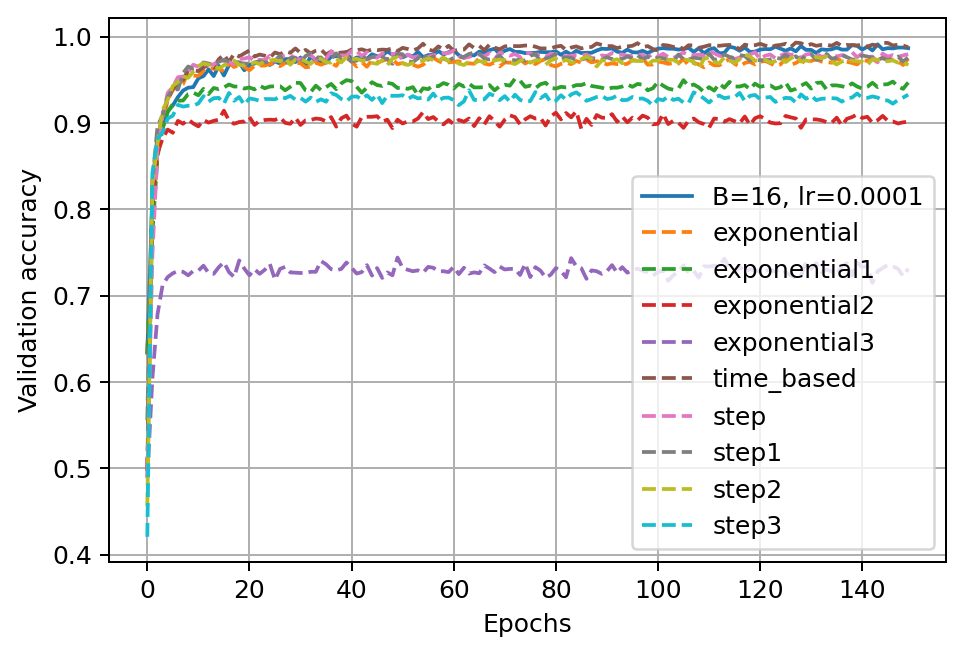

In [7]:
#----- Plottin the validation accuracy for different dynamic learning rates -----

va_16  = np.load(folder_step_1 + '/valid_accuracies_16_1.npy')

va_512_exponential = np.load(folder_step_2 + '/valid_accuracies_512_exponential.npy')
va_512_exponential1 = np.load(folder_step_2 + '/valid_accuracies_512_exponential1.npy')
va_512_exponential2 = np.load(folder_step_2 + '/valid_accuracies_512_exponential2.npy')
va_512_exponential3 = np.load(folder_step_2 + '/valid_accuracies_512_exponential3.npy')

va_512_time_based = np.load(folder_step_2 + '/valid_accuracies_512_time_based.npy')

va_512_step = np.load(folder_step_2 + '/valid_accuracies_512_step.npy')
va_512_step1 = np.load(folder_step_2 + '/valid_accuracies_512_step1.npy')
va_512_step2 = np.load(folder_step_2 + '/valid_accuracies_512_step2.npy')
va_512_step3 = np.load(folder_step_2 + '/valid_accuracies_512_step3.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')

fig1, ax1 = plt.subplots(dpi=180)

ax1.plot(epochs, va_16, label='B=16, lr=0.0001')

ax1.plot(epochs, va_512_exponential,'--', label='exponential')
ax1.plot(epochs, va_512_exponential1,'--', label='exponential1')
ax1.plot(epochs, va_512_exponential2,'--', label='exponential2')
ax1.plot(epochs, va_512_exponential3,'--', label='exponential3')

ax1.plot(epochs, va_512_time_based,'--', label='time_based')

ax1.plot(epochs, va_512_step,'--', label='step')
ax1.plot(epochs, va_512_step1,'--', label='step1')
ax1.plot(epochs, va_512_step2,'--', label='step2')
ax1.plot(epochs, va_512_step3,'--', label='step3')

ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation accuracy')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_2 + "/comparison_plot_512_lr_adaptive.tex")

fig1.savefig(folder_step_2 + "/comparison_plot_512_lr_adaptive.jpg", dpi=180)

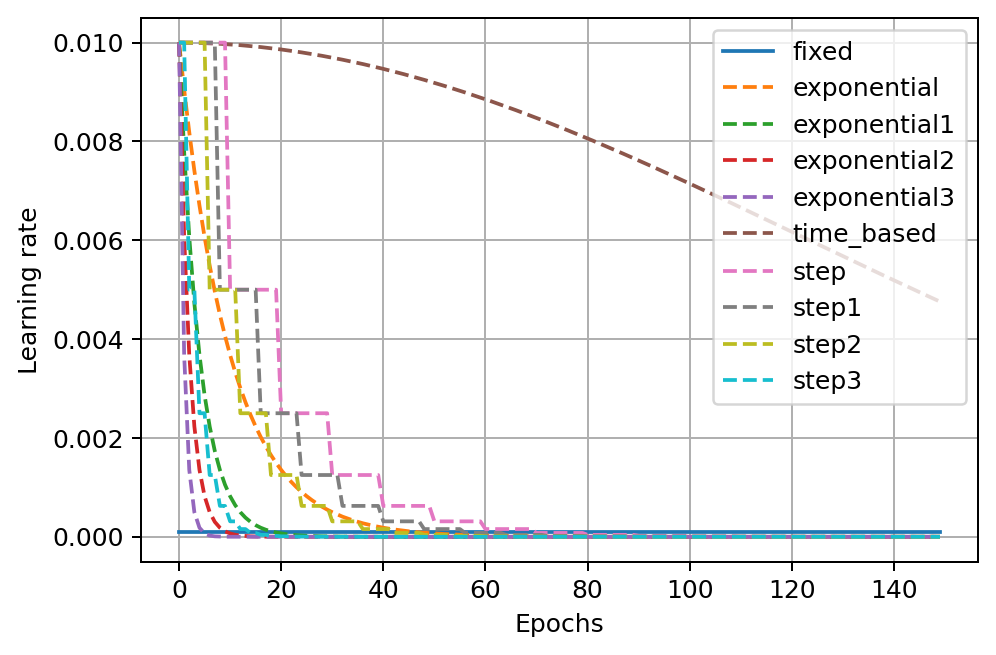

In [8]:
#----- Plotting the dynamic learning rate -----

lr_exponential = np.load(folder_step_2 + '/list_of_lr_512_exponential.npy')
lr_exponential1 = np.load(folder_step_2 + '/list_of_lr_512_exponential1.npy')
lr_exponential2 = np.load(folder_step_2 + '/list_of_lr_512_exponential2.npy')
lr_exponential3 = np.load(folder_step_2 + '/list_of_lr_512_exponential3.npy')

lr_step = np.load(folder_step_2 + '/list_of_lr_512_step.npy')
lr_step1 = np.load(folder_step_2 + '/list_of_lr_512_step1.npy')
lr_step2 = np.load(folder_step_2 + '/list_of_lr_512_step2.npy')
lr_step3 = np.load(folder_step_2 + '/list_of_lr_512_step3.npy')

lr_time_based = np.load(folder_step_2 + '/list_of_lr_512_time_based.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')

fig1, ax1 = plt.subplots(dpi=180)

lr = len(epochs)*[0.0001]

ax1.plot(epochs, lr, label='fixed')
ax1.plot(epochs, lr_exponential,'--', label='exponential')
ax1.plot(epochs, lr_exponential1,'--', label='exponential1')
ax1.plot(epochs, lr_exponential2,'--', label='exponential2')
ax1.plot(epochs, lr_exponential3,'--', label='exponential3')

ax1.plot(epochs, lr_time_based,'--', label='time_based')

ax1.plot(epochs, lr_step,'--', label='step')
ax1.plot(epochs, lr_step1,'--', label='step1')
ax1.plot(epochs, lr_step2,'--', label='step2')
ax1.plot(epochs, lr_step3,'--', label='step3')


ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Learning rate')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_2 + "/lr_adaptive.tex")

fig1.savefig(folder_step_2 + "/lr_adaptive.jpg", dpi=180)

# SGD with dynamic learning rate and dynamic batch size

Finally, we show that theoretical reasoning about the meaning of the ratio $\mu/B$ is supported by empirical evidence. We do this by analyzing the performance of the following 2 models:

1) Model trained with step-decay dynamic learning rate with $s=0.375$

2) Model trained with step-decay dynamic learning rate with $s=0.75$ and step-ascend dynamic batch size with $s_B=2$

In [ ]:
#----- Train function for the dynamic learning rate and batch size training -----

def train_adaptive_lr_and_b(net, criterion, optimizer, device, n_epochs, lr0):
    
    epochs = []
    train_losses = []
    valid_accuracies = []
    list_of_lr = []
    list_of_b = []
    
    drop = 0.75
    epochs_drop = 20
    
    print(f"The training is done on the {'GPU' if next(net.parameters()).is_cuda else 'CPU'}")
    
    b0 = 16
    bdrop = 2
    
    for epoch in range(n_epochs):

        lr = lr0*drop**np.floor(epoch / epochs_drop)
        b  = b0*bdrop**np.floor(epoch / epochs_drop)
        
        train_loader, valid_loader = data_loaders(int(b))

        train_loss = train_one_epoch(net, train_loader, criterion, optimizer, device, lr)
        
        epochs.append(epoch)
        train_losses.append(train_loss)

        accuracy = validate(net, valid_loader, device)
        valid_accuracies.append(accuracy)
        list_of_lr.append(lr)
        list_of_b.append(b)
        
        print(f"epoch {epoch} loss {train_loss:.3f} accuracy {100*accuracy:.2f}%")
        
    return epochs, train_losses, valid_accuracies, net, list_of_lr, list_of_b

In [ ]:
#----- Train function for the equivavlent step decay learning rate -----

def train_adaptive_lr_eq(net, train_loader, valid_loader, criterion, optimizer, device, n_epochs, lr0):
    
    epochs = []
    train_losses = []
    valid_accuracies = []
    list_of_lr = []
    
    drop = 0.375
    epochs_drop = 20
    
    print(f"The training is done on the {'GPU' if next(net.parameters()).is_cuda else 'CPU'}")
    
    lr = lr0
    
    for epoch in range(n_epochs):

        lr = lr0 * drop**np.floor(epoch / epochs_drop)

        train_loss = train_one_epoch(net, train_loader, criterion, optimizer, device, lr)
        
        epochs.append(epoch)
        train_losses.append(train_loss)

        accuracy = validate(net, valid_loader, device)
        valid_accuracies.append(accuracy)
        list_of_lr.append(lr)
        
        print(f"epoch {epoch} loss {train_loss:.3f} accuracy {100*accuracy:.2f}%")
        
    return epochs, train_losses, valid_accuracies, net, list_of_lr

In [9]:
#----- Create a path and folder for the results -----

current_folder = os.getcwd()

file = current_folder + '/Results'

if not os.path.isdir(file):
    os.makedirs(file)

folder_step_3 = file + '/SGD with variable learning rate and variable batch size'
if not os.path.isdir(folder_step_3):
    os.makedirs(folder_step_3)

In [ ]:
#----- Main function for the equivalence testing ----- 

n_epochs = 120

learning_rate = 0.0001
            
for param in model.features.parameters():
    param.requires_grad = False
    
# Reinitializing the parameters of the classification model
    
model.classifier[1] = nn.Linear(9216, 1024, bias=True)
model.classifier[4] = nn.Linear(1024 , 128, bias=True)
model.classifier[6] = nn.Linear(128 , 10 , bias=True)
        
model.to(device)
        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
criterion.to(device)
        
epochs, train_losses, valid_accuracies, net, list_of_lr, list_of_b = train_adaptive_lr_and_b(model, criterion, optimizer, device, n_epochs, learning_rate)
        
np.save(folder_step_3 + '/train_losses_adaptive_lr_and_b.npy', np.array(train_losses))
np.save(folder_step_3 + '/valid_accuracies_lr_and_b.npy', np.array(valid_accuracies))
np.save(folder_step_3 + '/list_of_lr_lr_and_b.npy', np.array(list_of_lr))
np.save(folder_step_3 + '/list_of_b_lr_and_b.npy', np.array(list_of_b))
        
torch.save(model.state_dict(), folder_step_3 + '/Model_lr_and_b.pt')
    
#----- The equivalent model with the same adaptive lr -----
    
#----- Reinitializing the parameters of the classification model -----

model.classifier[1] = nn.Linear(9216, 1024, bias=True)
model.classifier[4] = nn.Linear(1024 , 128, bias=True)
model.classifier[6] = nn.Linear(128 , 10 , bias=True)
        
model.to(device)
        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  
    
batch_size = 16
    
train_loader, valid_loader = data_loaders(batch_size) 
    
epochs, train_losses, valid_accuracies, net, list_of_lr = train_adaptive_lr_eq(model, train_loader, valid_loader, criterion, optimizer, device, n_epochs, learning_rate)
    
np.save(folder_step_3 + '/train_losses_adaptive_lr_eq.npy', np.array(train_losses))
np.save(folder_step_3 + '/valid_accuracies_lr_eq.npy', np.array(valid_accuracies))
np.save(folder_step_3 + '/list_of_lr_eq.npy', np.array(list_of_lr))
        
torch.save(model.state_dict(), folder_step_3 + '/Model_lr_eq.pt')

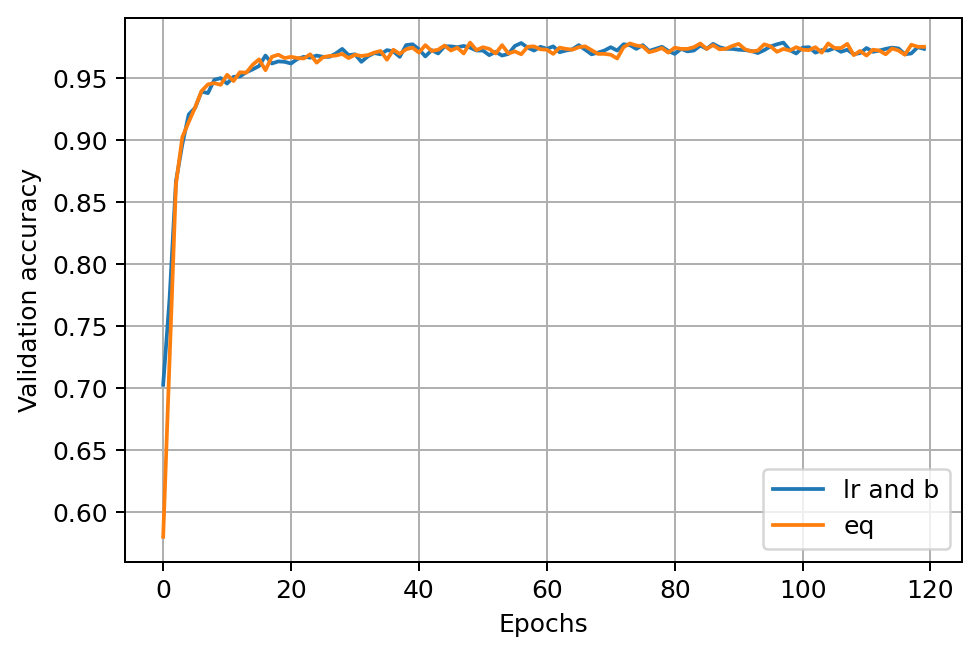

In [10]:
#----- Plotting the validation accuracy for the equivalence -----

list_of_b_lr_and_b = np.load(folder_step_3 + '/list_of_b_lr_and_b.npy')
list_of_lr_lr_and_b = np.load(folder_step_3 + '/list_of_lr_lr_and_b.npy')
list_of_lr_eq = np.load(folder_step_3 + '/list_of_lr_eq.npy')

va_lr_and_b = np.load(folder_step_3 + '/valid_accuracies_lr_and_b.npy')
va_eq = np.load(folder_step_3 + '/valid_accuracies_lr_eq.npy')

epochs = np.load(folder_step_1 + '/epochs.npy')
epochs = epochs[:120]

fig1, ax1 = plt.subplots(dpi=180)

ax1.plot(epochs, va_lr_and_b, label='lr and b')
ax1.plot(epochs, va_eq, label='eq')

ax1.grid('on')
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation accuracy')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_3 + "/lr_and_b_adaptive.tex")

fig1.savefig(folder_step_3 + "/lr_and_b_adaptive.jpg", dpi=180)

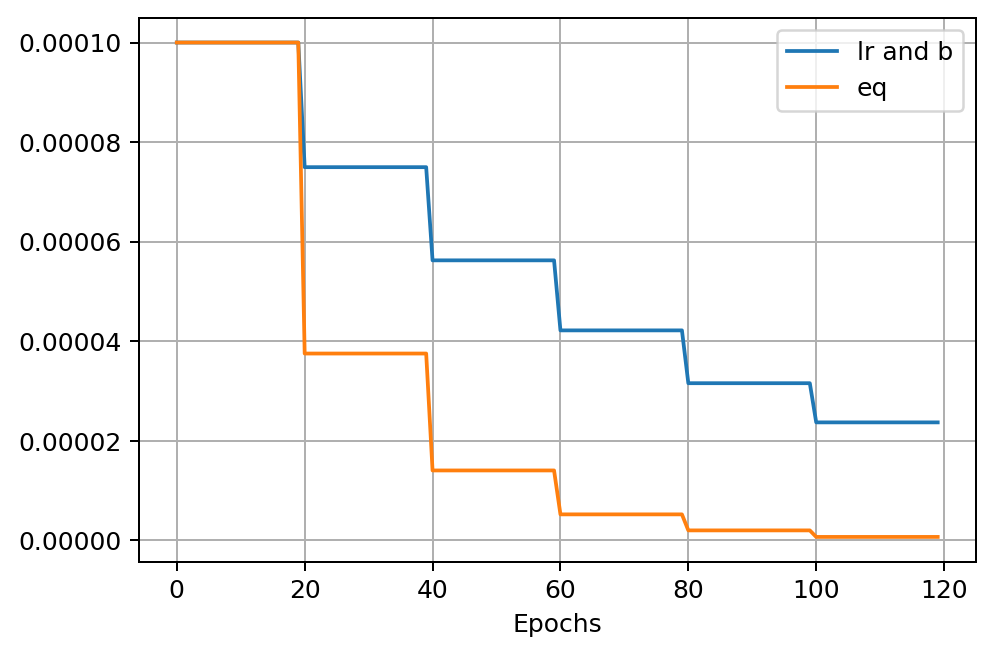

In [11]:
#---- Plotting the learning rate evolution -----

fig2, ax2 = plt.subplots(dpi=180)

ax2.plot(epochs, list_of_lr_lr_and_b, label='lr and b')
ax2.plot(epochs, list_of_lr_eq, label='eq')

ax2.grid('on')
ax2.legend()
ax2.set_xlabel('Epochs')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_3 + "/lr_and_b_adaptive_lr.tex")

fig2.savefig(folder_step_3 + "/lr_and_b_adaptive_lr.jpg", dpi=180)

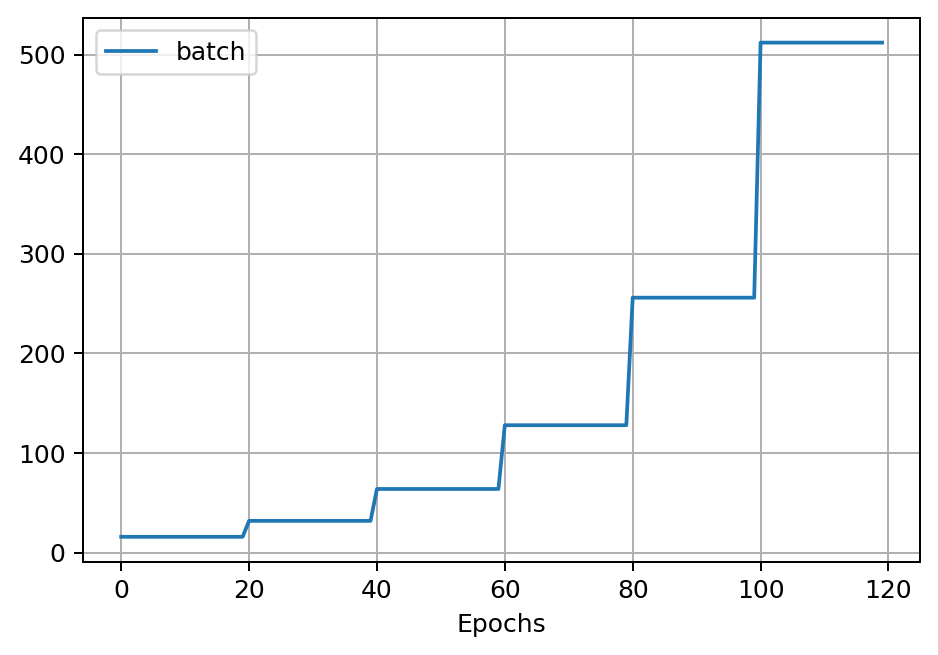

In [12]:
#----- Plotting the batch size evolution -----

fig3, ax3 = plt.subplots(dpi=180)

ax3.plot(epochs, list_of_b_lr_and_b, label='batch')

ax3.grid('on')
ax3.legend()
ax3.set_xlabel('Epochs')

tikzplotlib.clean_figure()
tikzplotlib.save(folder_step_3 + "/lr_and_b_adaptive_b.tex")

fig3.savefig(folder_step_3 + "/lr_and_b_adaptive_b.jpg", dpi=180)